In [108]:
import sklearn as sk
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels as stm

In [109]:
X = pd.read_csv('data/preprocessing/X_fill.csv')
y = pd.read_csv('data/preprocessing/y.csv')

In [110]:
X.columns

Index(['educ_center',
       'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
       'harass5_No', 'harass5_Yes', 'harass5_unknown', 'polviews_Conservative',
       'polviews_Extremely_liberal', 'polviews_Extrmly_conservative',
       'polviews_Liberal', 'polviews_Moderate',
       'polviews_Slghtly_conservative', 'polviews_Slightly_liberal',
       'polviews_unknown', 'advfront_Agree', 'advfront_Disagree',
       'advfront_Dont_know', 'advfront_Strongly_agree',
       'advfront_Strongly_disagree', 'advfront_unknown', 'snapchat_No',
       'snapchat_Yes', 'snapchat_unknown', 'instagrm_No', 'instagrm_Yes',
       'instagrm_unknown', 'wrkstat_Keeping_house', 'wrkstat_Other',
       'wrkstat_Retired', 'wrkstat_School', 'wrkstat_Temp_not_working',
       'wrkstat_Unempl,_laid_off', 'wrkstat_Working_fulltime',
       'wrkstat_Working_parttime', 'wrkstat_unknown'],
      dtype='object')

In [111]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 34 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   educ_center                                                      1649 non-null   float64
 1   harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)  1649 non-null   int64  
 2   harass5_No                                                       1649 non-null   int64  
 3   harass5_Yes                                                      1649 non-null   int64  
 4   harass5_unknown                                                  1649 non-null   int64  
 5   polviews_Conservative                                            1649 non-null   int64  
 6   polviews_Extremely_liberal                                       1649 non-null   int64  
 7   polviews_Extrmly_conservative             

In [112]:
size = y.shape[0]
mu = 0
sigma = 1e-3
noise = np.random.normal(mu,sigma,size)

In [113]:
y['noise'] = y['email_time_center'] + sigma

In [114]:
y[y['noise'] == 0]

,email_time_center,noise


array([[<Axes: title={'center': 'email_time_center'}>,
        <Axes: title={'center': 'noise'}>]], dtype=object)

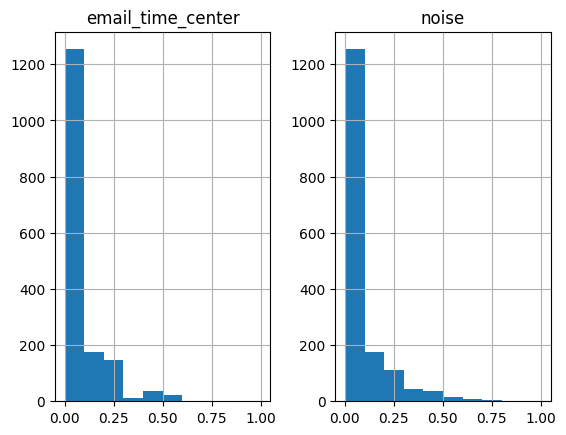

In [115]:
y.hist()

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y['noise'], test_size=0.2, random_state=0)

In [117]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1319, 34)
(330, 34)
(1319,)
(330,)


In [118]:
def print_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  
  print(f'metrics, mse: {mse}, rmse: {rmse}, r2: {r2}')

In [119]:
link_function = stm.genmod.families.links.Log()
gamma_model = stm.api.GLM(y_train, X_train, family=stm.api.families.Gamma(link=link_function))
# gamma_model = stm.api.GLM(y_train, X_train, family=stm.api.families.Gamma())
gamma_results = gamma_model.fit(method='lbfgs')
gamma_results.summary()

/home/linhnm/msc_code/social-stat-final-term/venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1291
Model Family:                   Gamma   Df Model:                           27
Link Function:                    Log   Scale:                          2.7239
Method:                         lbfgs   Log-Likelihood:                 2447.9
Date:                Mon, 14 Aug 2023   Deviance:                       2755.5
Time:                        21:38:14   Pearson chi2:                 3.52e+03
No. Iterations:                    80   Pseudo R-squ. (CS):             0.1181
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
educ_center                                                         1.7716      0.336      5.265      0.000       1.112       2.431
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)    -0.8868        nan        nan        nan         nan         nan
harass5_No                                                          0.1778        nan        nan        nan         nan         nan
harass5_Yes                                                         0.6711        nan        nan        nan         nan         nan
harass5_unknown                                                    -2.1613        nan        nan        nan         nan         nan
polviews_Conservative                                              -0.2150   4.75e+06  -4.53e-08      1.000   -9.31e+06    9.31e+06
polviews_Extremely_liberal                                         -0.2829    5.7e+06  -4.96e-08      1.000   -1.12e+07    1.12e+07
polviews_Extrmly_conservative                                      -0.7971    6.2e+06  -1.28e-07      1.000   -1.22e+07    1.22e+07
polviews_Liberal                                                   -0.3217   5.96e+06   -5.4e-08      1.000   -1.17e+07    1.17e+07
polviews_Moderate                                                  -0.1642    5.7e+06  -2.88e-08      1.000   -1.12e+07    1.12e+07
polviews_Slghtly_conservative                                      -0.3474   5.96e+06  -5.83e-08      1.000   -1.17e+07    1.17e+07
polviews_Slightly_liberal                                          -0.1373   5.96e+06   -2.3e-08      1.000   -1.17e+07    1.17e+07
polviews_unknown                                                    0.0666    4.2e+06   1.59e-08      1.000   -8.23e+06    8.23e+06
advfront_Agree                                                     -0.0715        nan        nan        nan         nan         nan
advfront_Disagree                                                   0.1699        nan        nan        nan         nan         nan
advfront_Dont_know                                                 -0.6111        nan        nan        nan         nan         nan
advfront_Strongly_agree                                            -0.0320   3.98e+06  -8.05e-09      1.000   -7.79e+06    7.79e+06
advfront_Strongly_disagree                                          0.9567      0.523      1.828      0.068      -0.069       1.983
advfront_unknown                                                   -2.6110          0       -inf      0.000      -2.611      -2.611
snapchat_No                                                        -0.8369   9.01e+06  -9.29e-08      1.000   -1.77e+07    1.77e+07
snapchat_Yes                                   

In [120]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1291
Model Family:                   Gamma   Df Model:                           27
Link Function:                    Log   Scale:                          2.7239
Method:                         lbfgs   Log-Likelihood:                 2447.9
Date:                Mon, 14 Aug 2023   Deviance:                       2755.5
Time:                        21:38:14   Pearson chi2:                 3.52e+03
No. Iterations:                    80   Pseudo R-squ. (CS):             0.1181
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
educ_center                                                         1.7716      0.336      5.265      0.000       1.112       2.431
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)    -0.8868        nan        nan        nan         nan         nan
harass5_No                                                          0.1778        nan        nan        nan         nan         nan
harass5_Yes                                                         0.6711        nan        nan        nan         nan         nan
harass5_unknown                                                    -2.1613        nan        nan        nan         nan         nan
polviews_Conservative                                              -0.2150   4.75e+06  -4.53e-08      1.000   -9.31e+06    9.31e+06
polviews_Extremely_liberal                                         -0.2829    5.7e+06  -4.96e-08      1.000   -1.12e+07    1.12e+07
polviews_Extrmly_conservative                                      -0.7971    6.2e+06  -1.28e-07      1.000   -1.22e+07    1.22e+07
polviews_Liberal                                                   -0.3217   5.96e+06   -5.4e-08      1.000   -1.17e+07    1.17e+07
polviews_Moderate                                                  -0.1642    5.7e+06  -2.88e-08      1.000   -1.12e+07    1.12e+07
polviews_Slghtly_conservative                                      -0.3474   5.96e+06  -5.83e-08      1.000   -1.17e+07    1.17e+07
polviews_Slightly_liberal                                          -0.1373   5.96e+06   -2.3e-08      1.000   -1.17e+07    1.17e+07
polviews_unknown                                                    0.0666    4.2e+06   1.59e-08      1.000   -8.23e+06    8.23e+06
advfront_Agree                                                     -0.0715        nan        nan        nan         nan         nan
advfront_Disagree                                                   0.1699        nan        nan        nan         nan         nan
advfront_Dont_know                                                 -0.6111        nan        nan        nan         nan         nan
advfront_Strongly_agree                                            -0.0320   3.98e+06  -8.05e-09      1.000   -7.79e+06    7.79e+06
advfront_Strongly_disagree                                          0.9567      0.523      1.828      0.068      -0.069       1.983
advfront_unknown                                                   -2.6110          0       -inf      0.000      -2.611      -2.611
snapchat_No                                                        -0.8369   9.01e+06  -9.29e-08      1.000   -1.77e+07    1.77e+07
snapchat_Yes                                   

In [121]:
y_pred = gamma_results.predict(X_test)
print_metrics(y_test, y_pred)

metrics, mse: 0.009030379207018904, rmse: 0.09502830739847419, r2: 0.08798772882752548


In [122]:
choices = ['educ_center', 'wrkstat_Working_fulltime']
# choices = ['educ_center', 'polviews_Extrmly conservative']
X_train_choice = X_train[X_train.columns.intersection(choices)]
X_test_choice = X_test[X_test.columns.intersection(choices)]

In [123]:
X_train_choice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 887 to 684
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   educ_center               1319 non-null   float64
 1   wrkstat_Working_fulltime  1319 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 30.9 KB


In [124]:
link_function = stm.genmod.families.links.Log()
gm_model = stm.api.GLM(y_train, X_train_choice, family=stm.api.families.Gamma(link=link_function))
gm_res = gm_model.fit(method='lbfgs')
gm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1317
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                          2.7854
Method:                         lbfgs   Log-Likelihood:                 2248.6
Date:                Mon, 14 Aug 2023   Deviance:                       3818.5
Time:                        21:38:14   Pearson chi2:                 3.67e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            -0.1811
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
educ_center                 -3.8550      0.097    -39.835      0.000      -4.045      -3.665
wrkstat_Working_fulltime     0.6379      0.101      6.324      0.000       0.440       0.836
============================================================================================
"""

In [125]:
y_pred = gm_res.predict(X_test_choice)

In [126]:
print(y_pred.shape)

(330,)


In [127]:
print_metrics(y_test, y_pred)

metrics, mse: 0.019575321230113085, rmse: 0.13991183377439195, r2: -0.9769859897057167
